In [32]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import pickle 
import pylab
import glob
from scipy import stats
import scikit_posthocs as sp
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
import ecopy
#from uncertainties import unumpy

import inverse_method_funs as inv
import sb_tools

%matplotlib inline

In [33]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [34]:
data = pd.read_feather('SSL_density.feather')
data_spec = pd.read_feather('SSL_density_spec.feather')

In [35]:
np.sum(data['source']=='Multinet')/5

11.0

## Anova assumption outliers
We have outlier (datapoints that don't fit in the boxes of the box plots , we can do with and without and see if it changes but let's avoid that

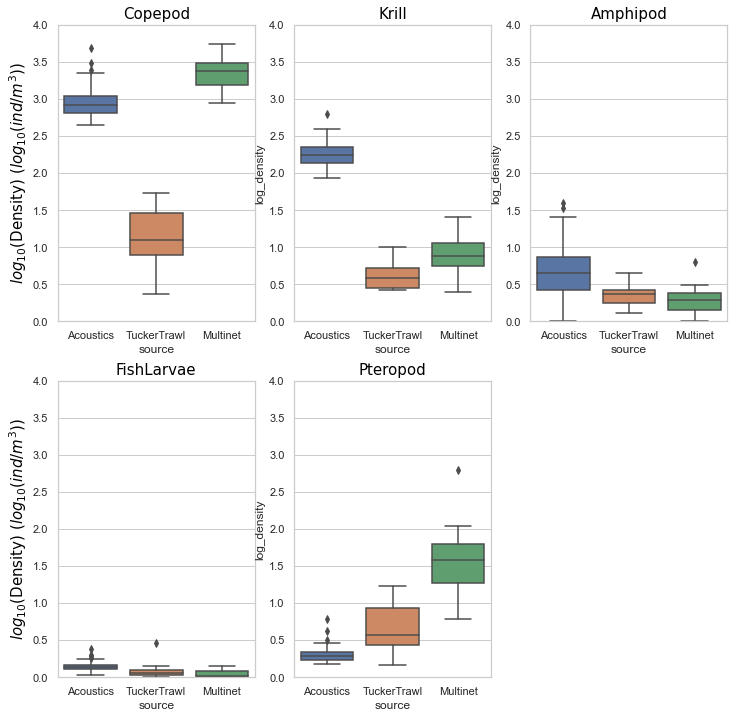

In [36]:
specs = ['Copepod', 'Krill', 'Amphipod', 'FishLarvae', 'Pteropod']
fig = plt.figure(figsize=(12,12))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);

## ANOVA assumption normal

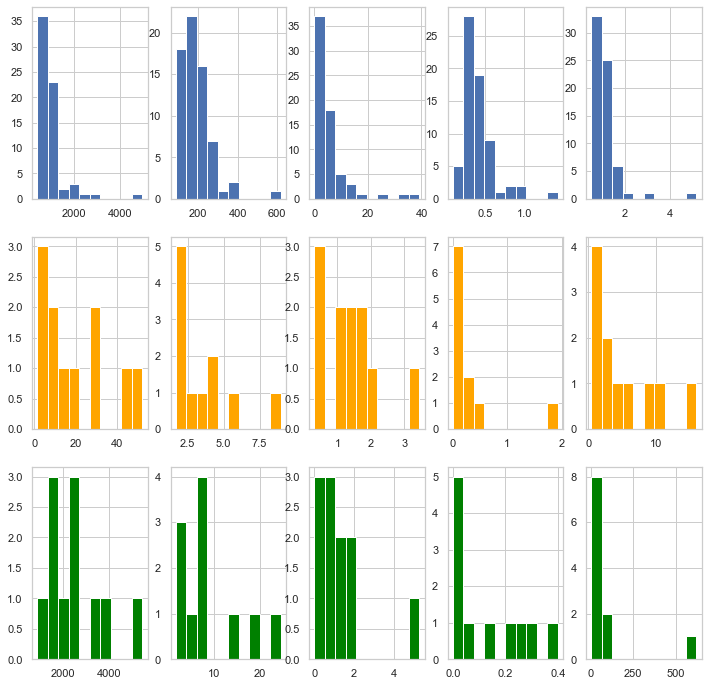

In [37]:
TT = data[data.source=='TuckerTrawl']
MN = data[data.source=='Multinet']
AA = data[data.source=='Acoustics']

fig = plt.figure(figsize=(12,12))
for ind_spec in range(len(specs)):
    ax = plt.subplot(3,5,ind_spec+1)
    plt.hist(AA.density[AA.species==specs[ind_spec]])
    ax = plt.subplot(3,5,ind_spec+6)
    plt.hist(TT.density[TT.species==specs[ind_spec]], color='orange')
    ax = plt.subplot(3,5,ind_spec+11)
    plt.hist(MN.density[MN.species==specs[ind_spec]], color='green')
    
    
    

# Not normal distributions

# Try Kruskal
It tests the null hypothesis that the population median of all the groups are equal.
Non parametric ANOVA

If pvalue is below significance, reject the null hypothesis that they are from the same group.

If H is bigger than Hc than null hypothesis is rejected

statistic is the H but what is my chi-squared

3 datasets -1 = 2 degrees of freedom
If I want a level of significance of 0.95 (statistical significance) then my chi-squared is 0.01 - From chi squared table (https://people.richland.edu/james/lecture/m170/tbl-chi.html)

In [38]:
KW=np.zeros((len(specs),2))

for ind_spec in range(len(specs)):
    KW[ind_spec,:] = stats.kruskal(AA.density[AA.species==specs[ind_spec]],TT.density[TT.species==specs[ind_spec]], MN.density[MN.species==specs[ind_spec]])

In [39]:
pd.DataFrame(data=KW, index=specs, columns=['Statistic', 'pvalue'])

,Statistic,pvalue
Copepod,43.204720,4.151588e-10
Krill,49.439440,1.838070e-11
Amphipod,22.819608,1.108626e-05
FishLarvae,26.376060,1.872886e-06
Pteropod,37.245613,8.169923e-09


*Analysed results from Kruskal*:
There was a significant difference between the sampling methods across all taxa (H(2)= 21 to 46, p= 2e-5 to 1e-10)

## Pairwise Compare Direct sampling methods

In [40]:
Dunn=np.zeros((3,3))

for ind_spec in range(len(specs)):
    Dunn = sp.posthoc_dunn([MN.density[MN.species==specs[ind_spec]],
                          TT.density[TT.species==specs[ind_spec]],
                          AA.density[AA.species==specs[ind_spec]]],
                        p_adjust='fdr_bh', sort=True)
    print(specs[ind_spec])
    print(Dunn)
    

Copepod
              1             2         3
1  1.000000e+00  1.798127e-10  0.000133
2  1.798127e-10  1.000000e+00  0.000003
3  1.325821e-04  2.969275e-06  1.000000
Krill
          1             2             3
1  1.000000  5.803379e-01  1.220045e-06
2  0.580338  1.000000e+00  4.626346e-08
3  0.000001  4.626346e-08  1.000000e+00
Amphipod
          1         2         3
1  1.000000  0.735109  0.000399
2  0.735109  1.000000  0.001098
3  0.000399  0.001098  1.000000
FishLarvae
          1         2         3
1  1.000000  0.447692  0.000044
2  0.447692  1.000000  0.001261
3  0.000044  0.001261  1.000000
Pteropod
              1         2             3
1  1.000000e+00  0.054514  5.251954e-08
2  5.451361e-02  1.000000  2.760512e-03
3  5.251954e-08  0.002761  1.000000e+00


In [42]:
Dunn

,1,2,3
1,1.000000e+00,0.054514,5.251954e-08
2,5.451361e-02,1.000000,2.760512e-03
3,5.251954e-08,0.002761,1.000000e+00


The results from the Kruskal-Wallis test are that the means are significantly different for the three sampling methods for each taxa. Then, we perform a Dunn's test determine which groups are different, we choose a post hoc Dunn's test instead of Wilcox because it does not require each group to have the same amount of entries.



## Diversity index using ecopy

In [43]:
x_density = data_spec.groupby('source').mean()[{'Copepod','Krill','Amphipod','FishLarvae','Pteropod'}]
x_density

,Krill,Amphipod,FishLarvae,Pteropod,Copepod
source,,,,,
Acoustic,190.282889,5.564515,0.41142,1.089999,1027.306349
Multinet,8.986724,1.260909,0.12381,92.539937,2534.240057
TuckerTrawl,3.500637,1.380798,0.31421,5.065019,19.321761


In [44]:
H = ecopy.diversity(x_density, method='shannon')
H

array([1.60022921, 1.1963621 , 2.78499148])

In [45]:
## Simpson's D
D = ecopy.diversity(x_density, method='simpson')
D

array([1.37393067, 1.08140997, 2.11767991])

### P-value comparison to chi-square
The pvalue is < chisquared for all but direct method comparison of fish larvae, amphipod and krill.
The difference between the acoustic data and the direct sampling is statistically significant.
The difference between the direct sampling methods are not statistically significant for krill, amphipod and fish larvae.